# Model Evaluation and Insights

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
df= pd.read_csv("/content/drive/MyDrive/UberFarePrediction/cleaned_uber_data.csv")

#### 1. Evaluate Model Performance

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [5]:
X= df.drop(columns=['fare_amount'])
y= df['fare_amount']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
#loading saved model
xgb_tuned= joblib.load("/content/drive/MyDrive/UberFarePrediction/tuned_xgboost_model.pkl")

In [8]:
#evaluate tuned model on training data
y_train_pred= xgb_tuned.predict(X_train)

mae_train= mean_absolute_error(y_train, y_train_pred)
rmse_train= np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train= r2_score(y_train, y_train_pred)

print("Training Evaluation of Tuned Random Forest:")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

Training Evaluation of Tuned Random Forest:
MAE: 2.2249
RMSE: 4.4306
R²: 0.7889


In [9]:
#evaluate tuned model on training data
y_pred= xgb_tuned.predict(X_test)

mae_test= mean_absolute_error(y_test, y_pred)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))
r2_test= r2_score(y_test, y_pred)

print("Test Evaluation of Tuned Random Forest:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Test Evaluation of Tuned Random Forest:
MAE: 2.2176
RMSE: 4.4079
R²: 0.7891


In [10]:
metrics_comparison= pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MAE": [mae_train, mae_test],
    "RMSE": [rmse_train, rmse_test],
    "R²": [r2_train, r2_test]
})
print(metrics_comparison)

  Dataset       MAE      RMSE        R²
0   Train  2.224931  4.430626  0.788877
1    Test  2.217625  4.407900  0.789089


The tuned XGBoost model shows good performance, with R² = 0.788 on training and 0.789 on testing. The train and test set errors are also close enough meaning the model generalizes well without overfitting.

#### 2. Feature Importance

Top Features Influencing Fare Prediction:
              Feature  Importance
6  trip_length_Medium    0.469134
7   trip_length_Short    0.307813
5       trip_distance    0.209833
1                hour    0.005031
4           rush_hour    0.002485
2         day_of_week    0.002163
3               month    0.002098
0     passenger_count    0.001441


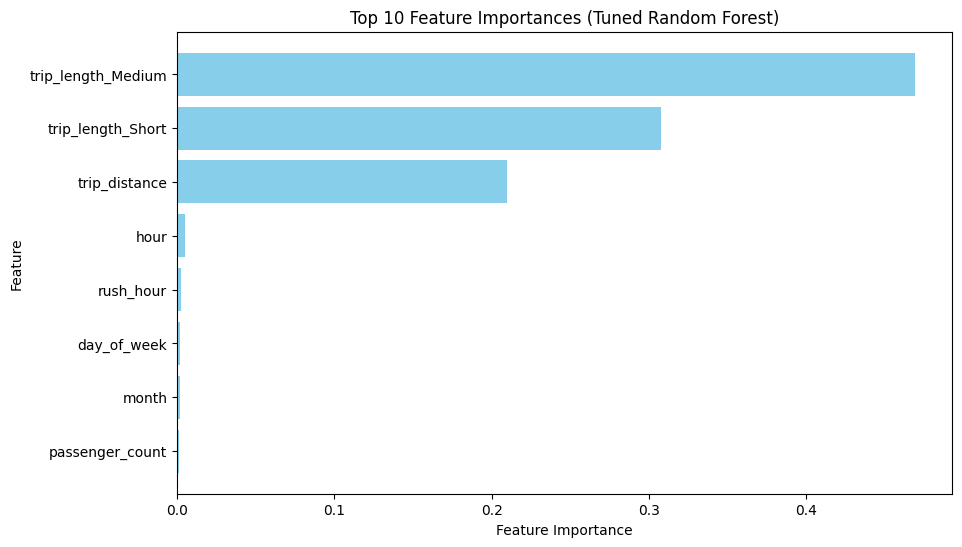

In [11]:
importance= xgb_tuned.feature_importances_
features= X_train.columns

feat_imp_df= pd.DataFrame({
    "Feature": features,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print("Top Features Influencing Fare Prediction:")
print(feat_imp_df.head(10))

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df["Feature"][:10], feat_imp_df["Importance"][:10], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Tuned Random Forest)")
plt.show()

The feature importance analysis shows that fare prediction is primarily driven by trip-related variables — with trip_length categories and trip_distance contributing the most. Other time-related features(hour, month, etc) and passenger_count have minimal impact, highlighting that distance is the key determinant of fare.

#### 3. Make Predictions on New Data

In [15]:
#new ride data
new_rides= pd.DataFrame({
    "passenger_count": [1, 2],
    "hour": [9, 18],                #morning vs evening
    "day_of_week": [2, 6],          #0=Monday, 6=Sunday
    "month": [5, 12],               #May, December
    "rush_hour": [1, 0],            #rush hour or not
    "trip_distance": [15.5, 25.2],  #in km
    "trip_length_Medium": [0, 0],   #One-hot encoding
    "trip_length_Short": [1, 0]     #One-hot encoding
})

#make predictions using tuned XGBoost model
new_predictions= xgb_tuned.predict(new_rides)

#combine inputs and predictions for display
new_rides["Predicted_Fare"]= new_predictions

print("New rides data:")
display(new_rides)

print("Predicted fares for new rides:")
print(new_rides["Predicted_Fare"].values)

New rides data:


,passenger_count,hour,day_of_week,month,rush_hour,trip_distance,trip_length_Medium,trip_length_Short,Predicted_Fare
0,1,9,2,5,1,15.5,0,1,36.717155
1,2,18,6,12,0,25.2,0,0,55.662296


Predicted fares for new rides:
[36.717155 55.662296]


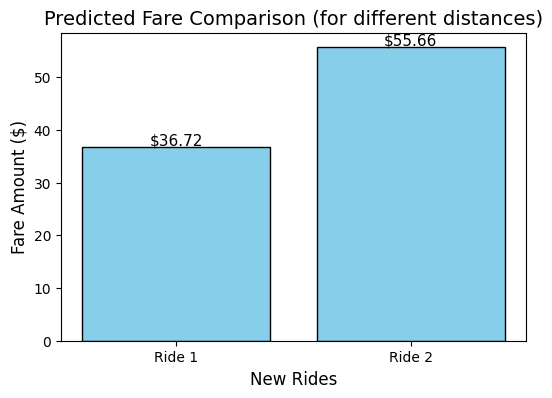

In [16]:
#bar plot for predicted fares
plt.figure(figsize=(6, 4))
plt.bar(["Ride 1", "Ride 2"], new_rides["Predicted_Fare"], color="skyblue", edgecolor="black")

plt.title("Predicted Fare Comparison (for different distances)", fontsize=14)
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.xlabel("New Rides", fontsize=12)

for i, val in enumerate(new_rides["Predicted_Fare"]):
    plt.text(i, val + 0.5, f"${val:.2f}", ha="center", fontsize=11)

plt.show()

The above bar plot shows how distance affects the fare prices.

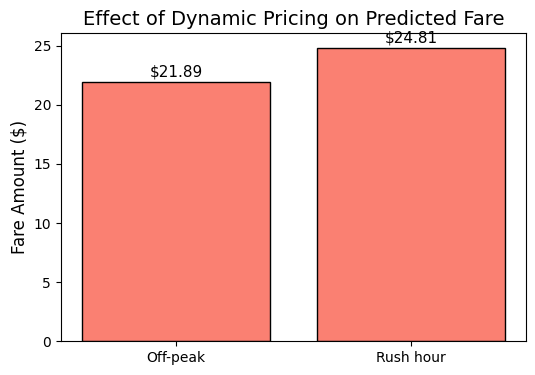

In [25]:
#new rides data for dynamic pricing effect
rides_dynamic= pd.DataFrame({
    "passenger_count": [1, 1],
    "hour": [22, 18],                 # night vs evening
    "day_of_week": [4, 4],            # same day
    "month": [7, 7],                  # same month
    "rush_hour": [0, 1],              # not rush hour vs rush hour
    "trip_distance": [10, 10],        # same distance
    "trip_length_Medium": [1, 1],
    "trip_length_Short": [0, 0]
})

rides_dynamic["Predicted_Fare"]= xgb_tuned.predict(rides_dynamic)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(["Off-peak", "Rush hour"], rides_dynamic["Predicted_Fare"],
        color="salmon", edgecolor="black")
plt.title("Effect of Dynamic Pricing on Predicted Fare", fontsize=14)
plt.ylabel("Fare Amount ($)", fontsize=12)

for i, val in enumerate(rides_dynamic["Predicted_Fare"]):
    plt.text(i, val + 0.5, f"${val:.2f}", ha="center", fontsize=11)

plt.show()

The same 10 km trip costs significantly more during rush hour compared to off-peak hours. This indicates Uber’s dynamic pricing mechanism, where fares increase to balance higher demand and limited driver availability during peak times.

These predictions allow the company to estimate fares in advance, improving pricing transparency for customers and helping drivers plan optimal trips. Such predictive insights can also detect unusual pricing patterns and support dynamic pricing strategies.

#### 4. Recommendations

1. Focus on Distance and Trip Length:

   From the model results, it’s clear that distance and trip length affect the fare the most. Uber can adjust its pricing by keeping these two factors as the base, so fares feel more fair and consistent.

2. Handle Rush Hour Pricing Carefully:

   Since prices go up during peak hours, Uber should keep using dynamic pricing but also make it more transparent. For example, showing customers why the price is higher or setting some limits can help build trust.

3. Encourage Drivers During Busy Times:

   Rush hours increase demand, so Uber can give small bonuses or incentives to drivers to be active during those periods. This will reduce waiting times for riders.

4. Use Predictions for Better Planning:

   The fare prediction model can also help Uber plan ahead by identifying when and where demand will be high. This way, more drivers can be placed in the right areas at the right time.

The regression models showed that trip distance and trip length are the main factors affecting fare prices. Among all models, the tuned XGBoost performed best, and it can be used to predict fares quite accurately. These insights can help Uber improve its pricing strategy and manage demand better.